In [30]:
# data from: https://www.kaggle.com/datasets/bahadoreizadkhah/face-mask-types-dataset/code
# reference: https://towardsdatascience.com/from-alexnet-to-nasnet-a-brief-history-and-introduction-of-convolutional-neural-networks-cf63bf3320e1 
# reference: https://github.com/Alexiush/weak-causality-and-causal-disposition-in-images/blob/main/ca_cnn_sample_resnet.ipynb

import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras import backend as K
from tensorflow.keras import models
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import pathlib

In [31]:
data_train = pathlib.Path('./Dataset/train')
data_test = pathlib.Path('./Dataset/test')

INPUT_SIZE = [300, 300]
BATCH = 6

In [32]:
training_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest",
    validation_split=0.0,
    rescale=1./255
)

training_data = training_datagen.flow_from_directory('./Dataset/train',
                                                     subset="training",
                                                     shuffle=True,
                                                     target_size=INPUT_SIZE,
                                                     batch_size=BATCH,
                                                     color_mode="rgb",
                                                     # interpolation="bilinear", 
                                                     class_mode='categorical')

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

test_data = test_datagen.flow_from_directory('./Dataset/test',
                                             target_size=INPUT_SIZE,
                                             color_mode="rgb",
                                             batch_size=BATCH,
                                             class_mode='categorical',
                                             shuffle=False)

x_test, y_test = next(test_data)
x_train, y_train = next(training_data)

Found 1956 images belonging to 5 classes.
Found 330 images belonging to 5 classes.


In [33]:
vgg_model = tf.keras.applications.VGG16(input_shape=(300, 300, 3), include_top=False, weights='imagenet')

vgg_model.trainable = True

fine_tune_at = 100
for layer in vgg_model.layers[:fine_tune_at]:
    layer.trainable =  False

# model = models.Sequential([# Lambda(lambda x: x, input_shape=(300, 300, 3)), 
#     tf.keras.layers.InputLayer((300, 300, 3)),
#     vgg_model,
#     GlobalAveragePooling2D(),
#     Flatten(),
#     Dense(5, activation='softmax')])

flatten = Flatten()(vgg_model.output)
dense_1 = Dense(units=500, activation='relu')(flatten)
dense_2 = Dense(units=500, activation='relu')(dense_1)
dense_3 = Dense(units=100, activation='relu')(dense_2)
dense_4 = Dense(units=100, activation='relu')(dense_3)
dense_output = Dense(units=5, activation='softmax')(dense_4)

model = models.Model(inputs=vgg_model.input, outputs=dense_output)
model.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 300, 300, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 300, 300, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 300, 300, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 150, 150, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 150, 150, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 150, 150, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 75, 75, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 75, 75, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 75, 75, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 75, 75, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 37, 37, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 37, 37, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 37, 37, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 37, 37, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 18, 18, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 9, 9, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 41472)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 500)            │    20,736,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 500)            │       250,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 100)            │        50,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 5)              │           50

 Total params: 35,762,393 (136.42 MB)

 Trainable params: 21,047,705 (80.29 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [34]:
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)
#  optimizer=tf.keras.optimizers.SGD(learning_rate=0.01)

history = model.fit(
    training_data,
    validation_data=test_data,
    epochs=5,
    # batch_size=BATCH,
    # steps_per_epoch=len(training_data),
    # validation_steps=len(test_data)
)

Epoch 1/5


/Users/ashleycui/miniconda3/envs/tf2/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


326/326 ━━━━━━━━━━━━━━━━━━━━ 380s 1s/step - accuracy: 0.3768 - loss: 1.8457 - val_accuracy: 0.5121 - val_loss: 1.1877
Epoch 2/5
326/326 ━━━━━━━━━━━━━━━━━━━━ 627s 2s/step - accuracy: 0.5848 - loss: 1.0612 - val_accuracy: 0.6364 - val_loss: 0.9801
Epoch 3/5
326/326 ━━━━━━━━━━━━━━━━━━━━ 582s 2s/step - accuracy: 0.6647 - loss: 0.8745 - val_accuracy: 0.7333 - val_loss: 0.7597
Epoch 4/5
326/326 ━━━━━━━━━━━━━━━━━━━━ 503s 2s/step - accuracy: 0.6640 - loss: 0.8557 - val_accuracy: 0.6697 - val_loss: 0.9272
Epoch 5/5
326/326 ━━━━━━━━━━━━━━━━━━━━ 542s 2s/step - accuracy: 0.7138 - loss: 0.7722 - val_accuracy: 0.6485 - val_loss: 0.8679


In [37]:
#Creacion de la matriz de confusion
y_pred=model.predict(test_data, batch_size=BATCH)
print(y_pred.shape)

y_pred = np.argmax(y_pred, axis=1)
print(y_pred)

cm=confusion_matrix(test_data.classes, y_pred)
print(cm)

#Impresion de la exactitud
accu = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
accu =accu.diagonal()
print(accu)

#Reporte de metricas
target_names = ['KN95', 'N95', 'Generico', 'Quirurgico', 'Sin_cubrebocas']
print(classification_report(test_data.classes, y_pred, target_names=target_names, digits=4))

# loss, accuracy, specificity, precision, recall = model.evaluate(test_data, verbose=0)
loss, accuracy = model.evaluate(test_data, verbose=0)

print(loss, accuracy)

55/55 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step
(330, 5)
[2 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 4 3 0 0 0 0 0 0 0 0 0 0 3 2 0 0 0 0 0
 0 3 4 0 0 0 3 0 0 0 2 3 3 0 0 0 0 3 0 1 0 0 0 0 0 0 0 0 3 0 0 0 3 3 0 0 0
 0 0 2 0 1 1 0 1 0 0 1 0 0 1 0 1 1 1 1 1 1 0 1 0 2 0 1 2 2 3 2 1 0 0 1 1 1
 1 0 1 0 2 1 1 2 1 1 2 1 0 1 1 1 1 2 2 0 2 2 2 2 2 2 2 1 2 2 2 2 0 2 2 4 2
 2 2 2 2 2 2 2 2 0 2 2 2 2 2 2 2 2 0 2 2 0 2 2 1 2 2 2 1 2 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 0 3 3 3 3 3 3 3 0 3 3 0 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 2 3 3 3 0 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 2 1 0
 1 1 4 0 0 4 0 0 4 1 1 0 0 0 0 0 0 0 0 0 0 4 0 0 0 0 0 0 4 0 4 0 0 1 1 0 0
 0 0 0 0 4 0 0 0 1 0 0 0 0 0 0 1 0 2 0 3 0 1 0 0 4 4 0 4 0 4 4 2 0 0]
[[60  1  5 10  2]
 [14 28  7  1  0]
 [ 5  3 40  0  1]
 [ 4  0  1 73  0]
 [48 10  3  1 13]]
[0.76923077 0.56       0.81632653 0.93589744 0.17333333]
                precision    recall  f1-score   support

          KN95     0.4580    0.7692    0.5742        78
           N95     0.

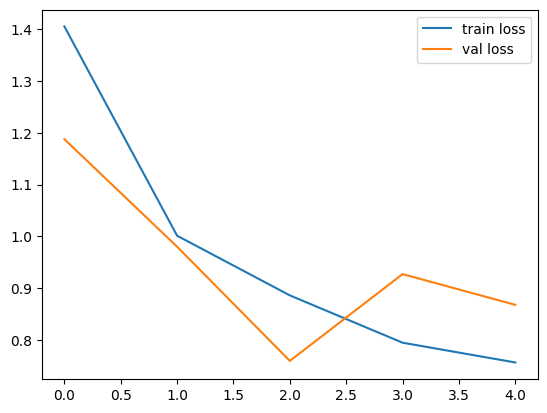

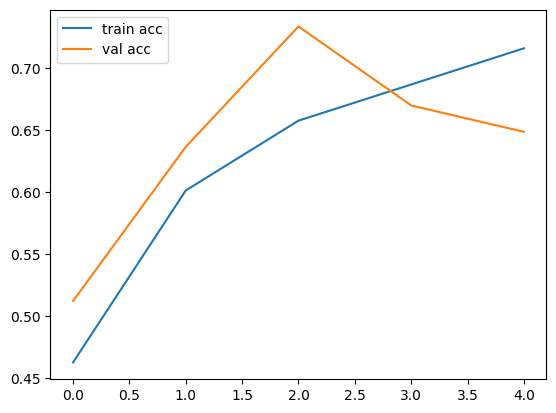

In [38]:
# plot the loss
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()
# plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
# plt.savefig('AccVal_acc')
import numpy as np

In [39]:
test_image = tf.keras.preprocessing.image.load_img(
    './Dataset/test/nfm/1.jpg',
    target_size=INPUT_SIZE)
test_image = tf.keras.preprocessing.image.img_to_array(test_image)
test_image = test_image / 255
test_image = np.expand_dims(test_image, axis=0)
result = model.predict(test_image)
i = np.argmax(result[0])
classes = training_data.class_indices.keys()
print(classes)
list(classes)[i]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 752ms/step
dict_keys(['cloth', 'n95', 'n95v', 'nfm', 'srg'])


'nfm'